We are upgrading our model from bigrams to Multi Layer Perceptrons

-Like word embeddings where words are embedded in n dimension(30 in researh paper) space to identify the patterns; we'll use 2D space to embed letters (character language model)

-We'll then use cross entropy loss function to calculate loss and divide the data into train dev and test sets to check over/under fitting

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

In [2]:
#Do a embedding in a muti dimensional space(m=30), so each word will be a vector in 30 dimensional space.
#Initially these are spread out randomly, we tune it with backpropagation
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
#print(chars)
stoi = {s:i+1 for i,s in enumerate(chars)}
print(stoi)
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
#print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size
  #print(context)
  for ch in w + '.':
    ix = stoi[ch]
    #print(ix)
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
    #print(context)

X = torch.tensor(X)
print(X)
Y = torch.tensor(Y)
print(Y)

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


In [5]:
X.shape, X.dtype, Y.shape, Y.dtype
#print(X[13,2])

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [6]:
# We are dealing with letter(27) and not words so intstead of embedding 17,000 words in a 30 dimensional space
#We'll embedd 27 vectors corresponding to the letters in a 2D space
C = torch.randn((27, 2))
print(C[5])
#Another way to form C
print(F.one_hot(torch.tensor(5), num_classes=27).float())
F.one_hot(torch.tensor(5), num_classes=27).float()@C #it will do the one hot encoding of the number 5 and ensure total 27 ho becoz 27 letters


tensor([-0.8037,  0.6108])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


tensor([-0.8037,  0.6108])

In [7]:
emb=C[X]
emb.shape

torch.Size([228146, 3, 2])

In [8]:
W1=torch.randn(6,100) #Number of inputs=6, 2 features for each letter and total 3 letters in one input example
#Number of neurons is upto us, so we took 100
b1=torch.randn(100)
#We can't directly use W1@emb+b1 as the emb dimension is 3X2
torch.cat([emb[:, 0, :],emb[:, 1, :],emb[:, 2, :]], 1).shape #Column ke about concatenate ho jayega
#This would not generalise if we change the block size from 3 to something else

torch.Size([228146, 6])

In [9]:
h=torch.tanh(emb.view(emb.shape[0], 6)@W1+b1)

In [10]:
#print(torch.unbind(emb, 1))
#torch.cat(torch.unbind(emb,1),1).shape
torch.cat(torch.unbind(emb,1),1)#Unefficient .cat() method as it creates new memory

tensor([[-0.7283,  0.3086, -0.7283,  0.3086, -0.7283,  0.3086],
        [-0.7283,  0.3086, -0.7283,  0.3086, -0.8037,  0.6108],
        [-0.7283,  0.3086, -0.8037,  0.6108,  1.1811,  0.1280],
        ...,
        [-0.0567, -1.0210, -0.0567, -1.0210, -0.9227,  0.5604],
        [-0.0567, -1.0210, -0.9227,  0.5604, -0.0567, -1.0210],
        [-0.9227,  0.5604, -0.0567, -1.0210, -0.2811, -0.2059]])

In [11]:
#More efficient ways to do this
a=torch.arange(18)
a.view(2,9)
a.view(2,3,3)
#All arrays are stored in a 1D array in computer

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]]])

In [12]:
#emb.storage()
emb.view(-1,6)
#emb.view(32,6)==torch.cat(torch.unbind(emb,1),1)

tensor([[-0.7283,  0.3086, -0.7283,  0.3086, -0.7283,  0.3086],
        [-0.7283,  0.3086, -0.7283,  0.3086, -0.8037,  0.6108],
        [-0.7283,  0.3086, -0.8037,  0.6108,  1.1811,  0.1280],
        ...,
        [-0.0567, -1.0210, -0.0567, -1.0210, -0.9227,  0.5604],
        [-0.0567, -1.0210, -0.9227,  0.5604, -0.0567, -1.0210],
        [-0.9227,  0.5604, -0.0567, -1.0210, -0.2811, -0.2059]])

In [13]:
W2=torch.randn(100,27)
b2=torch.randn(27)
logits=h@W2+b2
logits.shape

torch.Size([228146, 27])

In [14]:
counts=logits.exp()
prob=counts/counts.sum(1, keepdim=True)
#prob[0].sum()

In [15]:
prob[torch.arange(X.shape[0]), Y].shape
loss=-prob[torch.arange(X.shape[0]), Y].log().mean()

In [16]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [17]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [18]:
emb=C[X]
h=torch.tanh(emb.view(-1,6)@W1+b1)
# logits=h@W2+b2
# counts=logits.exp()
# prob=counts/counts.sum(1, keepdim=True)
# loss=-prob[torch.arange(32), Y].log().mean()
# loss
#Also if very high number is put in the above formula we might get infinity in the counts

#More efficient algorithm
F.cross_entropy(logits, Y)

tensor(14.5775)

In [19]:
F.cross_entropy(logits, Y)
for p in parameters:
  p.requires_grad=True

In [20]:
lre = torch.linspace(-3, 0, 10000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [21]:
for i in range(10000):#Can do it for 100000 to get a very low loss
  #mini batches
  ix = torch.randint(0, X.shape[0], (32,))

  #forward pass
  emb = C[X[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  #lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

3.599872350692749


In [22]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss #loss for all the examples

tensor(3.8609, grad_fn=<NllLossBackward0>)

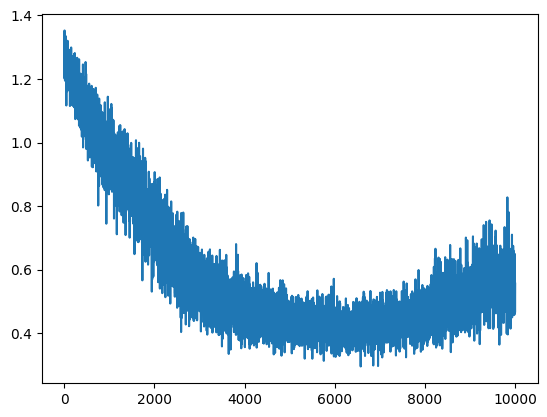

In [23]:
plt.plot(stepi, lossi)

In [24]:
#training split, data validation split, test split
#80,10,10
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80% for training
Xdev, Ydev = build_dataset(words[n1:n2])#10% for dev
Xte, Yte = build_dataset(words[n2:])#10% for testing

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [25]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [26]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [27]:
for p in parameters:
  p.requires_grad = True

In [28]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [29]:
lri = []
lossi = []
stepi = []

In [30]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [31]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1176, grad_fn=<NllLossBackward0>)

In [32]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss
#Here dev and train sets have the same error which means that we are not overfitting we are underfitting


tensor(2.1585, grad_fn=<NllLossBackward0>)

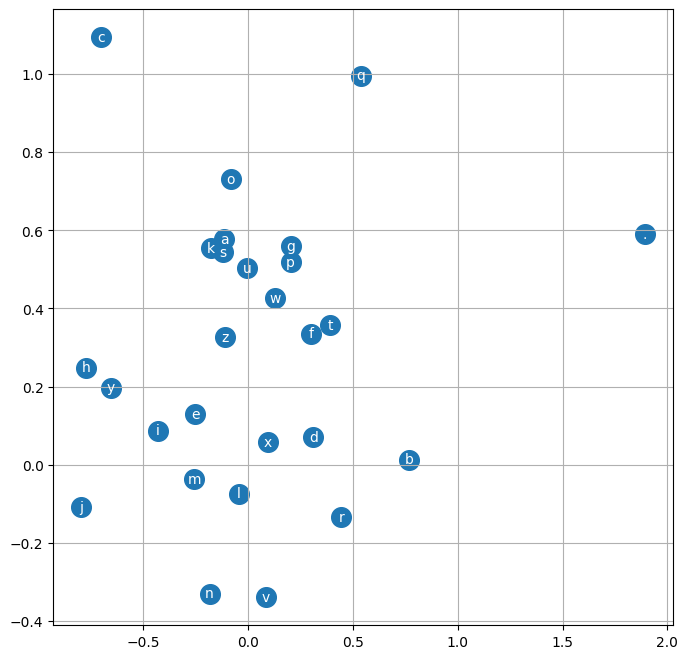

In [33]:
#It might happen that 27 letters are cramped too much into 2 features. We can try increasing the features also in the above code from 3 to 30
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

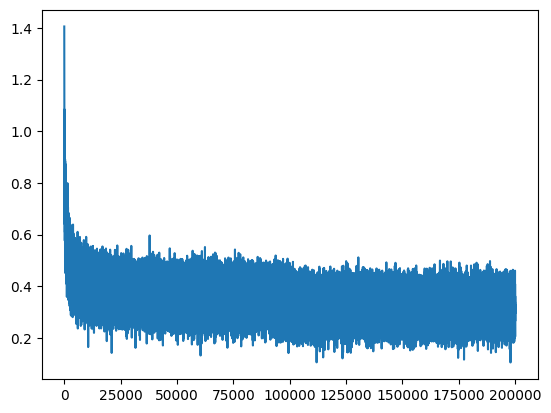

In [34]:
plt.plot(stepi, lossi)

In [35]:
g = torch.Generator().manual_seed(283647 + 10)
for i in range(500):
  out=[]
  context=[0]*block_size
  while True:
    emb=C[torch.tensor([context])]
    h=torch.tanh(emb.view(1, -1)@W1+b1)
    logits=h@W2+b2
    probs=F.softmax(logits, dim=1)
    ix=torch.multinomial(probs, num_samples=1, generator=g).item()
    context=context[1:]+[ix]
    out.append(ix)
    if ix==0:
      break
  print(''.join(itos[i] for i in out))

kellie.
brilyn.
rositlyn.
aren.
vaya.
kie.
briann.
neklyn.
anna.
ashlin.
nah.
lo.
far.
emlyn.
tie.
eakonra.
bas.
alee.
cantharieceana.
madyn.
aliler.
an.
uven.
zay.
jire.
sandrestin.
wilio.
alear.
dena.
jena.
areelesh.
jazlina.
iven.
samya.
ferraylia.
jasiab.
mae.
bria.
meha.
octorie.
marishiraliyannah.
vis.
hazinikaelenelle.
kalone.
alalande.
sivannaqubrixabeth.
jenes.
meer.
mikaima.
jen.
ell.
norienyn.
jurran.
khyt.
azt.
bak.
nogom.
taine.
praj.
zalina.
frne.
jhuviana.
zaughy.
jess.
itnadicolnot.
adie.
jasperainettaniel.
kin.
taim.
miham.
camderekell.
glode.
zaiah.
yxa.
jarmalineddin.
sta.
zailiviah.
lyny.
lylaniell.
kin.
pristinora.
issorah.
juer.
mard.
zykonlus.
zhyah.
emmires.
maha.
sammi.
galphreslynn.
ridyn.
zhankelseowfunda.
divant.
acarie.
adtefatal.
veinicoae.
balisiah.
masellillianna.
adi.
ammiela.
albin.
auda.
wartini.
den.
seagrifenyonnah.
caytanairistis.
onsjoyah.
fahtarti.
eis.
coln.
lyz.
navi.
sivik.
harigh.
jamira.
bochy.
ramari.
jasliyah.
hajir.
sara.
quel.
alayna.
ne